In [2]:
import os,keras,cv2 #cv2 requiered for selective search on images
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [3]:
train_images=[]
train_labels=[]

paths = "photos_test"
annot = "anotations_test"

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("tuberculosis"):
            filename=i.split(".")[0]+".jpg"
            image=cv2.imread(os.path.join(paths,filename))
            df=pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e<2000 and flag ==0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

inside


In [4]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

print(X_new.shape)
print(y_new.shape)

np.save("X_new",X_new)
np.save("y_new",y_new)

#res=np.load("X_new.npy")

#print(res.shape)

(39565, 224, 224, 3)
(39565,)


In [4]:
X_new=np.load("X_new.npy")
y_new=np.load("Y_new.npy")

Start creating the model

In [5]:
import keras, os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator


In [6]:
model=Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,
kernel_size=(3,3),padding="same",activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),
padding="same",activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256,kernel_size=(3,3),
padding="same",activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512,kernel_size=(3,3),
padding="same",activation="relu"))

model.add(Flatten())

model.add(Dense(units=4096,activation="relu"))

model.add(Dense(units=2, activation="softmax"))

2022-05-02 10:54:43.372926: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 256)      0

In [8]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 256)      0

In [10]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(35608, 224, 224, 3) (3957, 224, 224, 3) (35608, 2) (3957, 2)


In [11]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("model_test.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model.fit(x= traindata, steps_per_epoch= 10, epochs= 20, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

Epoch 1/20
 1/10 [==>...........................] - ETA: 41:25 - loss: 8.5713 - accuracy: 0.0938

Error: Canceled future for execute_request message before replies were done

In [11]:
import joblib
joblib.dump(model, 'model.pkl')

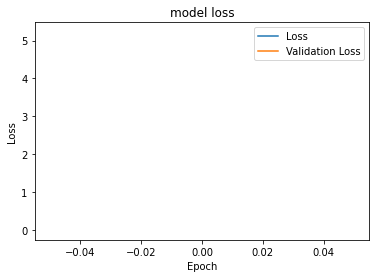

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

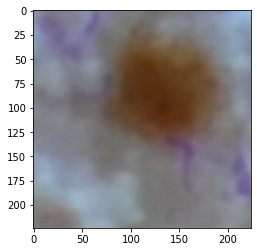

In [18]:
for image in range(X_test.shape[0]):
  im = X_test[image]
  img = np.expand_dims(im, axis=0)
  out= model.predict(img)

  if out[0][0] > out[0][1]:
    plt.figure()
    im = X_test[image]
    plt.imshow(im)


plt.imshow(im)

In [19]:
z=0
path_test="testph"
anotations_test="testanot"

false_negative=0
true_negative=0
true_positive=0
false_positive=0

for e,i in enumerate(os.listdir(anotations_test)):
    if i.startswith("tub"):
        z += 1
        filename=i.split(".")[0]+".jpg"
        img=cv2.imread(os.path.join(path_test,filename))
        df=pd.read_csv(os.path.join(anotations_test,i))
        gtvalues=[]
        for row in df.iterrows():
          x1 = int(row[1][0].split(" ")[0])
          y1 = int(row[1][0].split(" ")[1])
          x2 = int(row[1][0].split(" ")[2])
          y2 = int(row[1][0].split(" ")[3])
          gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()

        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model.predict(img)
                positive_flag=False
                if out[0][0] > 0.60:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if(iou>0.7):
                          positive_flag=True
                        break
                    if(positive_flag==True):
                      true_positive+=1
                    else:
                      false_positive+=1
                else:
                  for gtval in gtvalues:
                      x,y,w,h = result
                      iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                      if(iou>0.7):
                        positive_flag=True
                      break
                  if(positive_flag==True):
                    false_negative+=1
                  else:
                    true_negative+=1


print("Confusion Matrix:")
print()
print("     ","prediction")
print("    ","true"," ","False")
print("true ",true_positive,"   ",false_positive)
print("false",false_negative,"   ",true_negative)


Confusion Matrix:

      prediction
     true   False
true  0     0
false 0     4000
